# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [02:30, 1.21MB/s]                              
SVHN Testing Set: 64.3MB [01:25, 753KB/s]                             


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

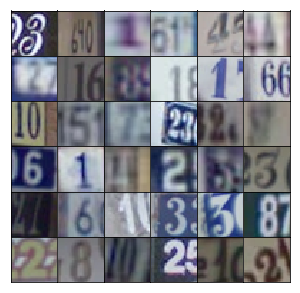

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [27]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        # TF does not have leaky ReLU built in, so we use no
        # activation fuction but create it afterwards
        h1 = tf.layers.dense(z, 4*4*512, activation=None)
        # Reshape into 3d array to start the convolutional part of the network.
        h1 = tf.reshape(h1, (-1, 4, 4, 512))
        # Batch normalization.
        h1 = tf.layers.batch_normalization(h1, training=training)
        # Leaky ReLU activation function.
        # Leaky ReLU simply does not evaluate to zero for zero or negaitve
        # inputs but to alpha * h1. The function below is not exactly that
        # in the range from 0 to alpha * h1, but what the heck...
        h1 = tf.maximum(alpha * h1, h1)
        # h1 now has a dimension of 4x4x512
        
       # 2nd convolutional layer 8x8x256
        h2 = tf.layers.conv2d_transpose(h1, filters=256, kernel_size=5, strides=(2,2), padding='same')
        # Batch normalization.
        h2 = tf.layers.batch_normalization(h2, training=training)
         # Leaky ReLU.
        h2 = tf.maximum(alpha * h2, h2)
            
        # 3rd convolutional layer 16x16x128
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=(2,2), padding='same')
        # Batch normalization.
        h3 = tf.layers.batch_normalization(h3, training=training)
         # Leaky ReLU.
        h3 = tf.maximum(alpha * h3, h3)
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(inputs=h3, filters= output_dim, kernel_size=5, strides=(2,2), padding='same')
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [35]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 1st convolutional layer.
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=(2,2), padding='same')
        # Batch normalization. DON'T USE HERE...
        #h1 = tf.layers.batch_normalization(h1, training=True)
         # Leaky ReLU.
        h1 = tf.maximum(alpha * h1, h1)
        
        # 2nd convolutional layer.
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=(2,2), padding='same')
        # Batch normalization.
        h2 = tf.layers.batch_normalization(h2, training=True)
         # Leaky ReLU.
        h2 = tf.maximum(alpha * h2, h2)
        
        # 3rd convolutional layer.
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=(2,2), padding='same')
        # Batch normalization.
        h3 = tf.layers.batch_normalization(h3, training=True)
         # Leaky ReLU.
        h3 = tf.maximum(alpha * h3, h3)
        
        # Turn last layer into vector.
        h3 = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(h3, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [36]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [38]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [39]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [40]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 64
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 1.2364... Generator Loss: 0.6304
Epoch 1/25... Discriminator Loss: 0.3420... Generator Loss: 1.7850
Epoch 1/25... Discriminator Loss: 0.2400... Generator Loss: 2.5804
Epoch 1/25... Discriminator Loss: 0.1316... Generator Loss: 2.6468
Epoch 1/25... Discriminator Loss: 0.1180... Generator Loss: 2.9273
Epoch 1/25... Discriminator Loss: 0.1571... Generator Loss: 2.5179
Epoch 1/25... Discriminator Loss: 0.0488... Generator Loss: 4.3425
Epoch 1/25... Discriminator Loss: 0.0692... Generator Loss: 3.6038
Epoch 1/25... Discriminator Loss: 0.2486... Generator Loss: 1.8282
Epoch 1/25... Discriminator Loss: 0.1418... Generator Loss: 3.3268


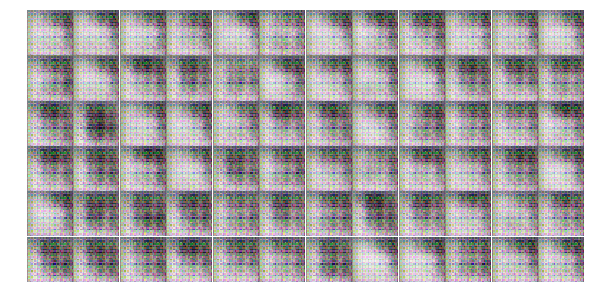

Epoch 1/25... Discriminator Loss: 1.0433... Generator Loss: 1.5532
Epoch 1/25... Discriminator Loss: 0.4677... Generator Loss: 2.2031
Epoch 1/25... Discriminator Loss: 0.4589... Generator Loss: 2.9173
Epoch 1/25... Discriminator Loss: 0.2945... Generator Loss: 2.3849
Epoch 1/25... Discriminator Loss: 0.3723... Generator Loss: 1.5148
Epoch 1/25... Discriminator Loss: 0.1626... Generator Loss: 3.1286
Epoch 1/25... Discriminator Loss: 0.1923... Generator Loss: 3.6687
Epoch 1/25... Discriminator Loss: 0.2336... Generator Loss: 3.3375
Epoch 1/25... Discriminator Loss: 0.1130... Generator Loss: 3.0232
Epoch 1/25... Discriminator Loss: 0.4087... Generator Loss: 2.4120


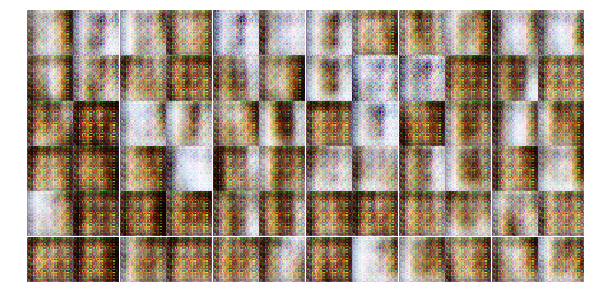

Epoch 1/25... Discriminator Loss: 0.4080... Generator Loss: 4.4539
Epoch 1/25... Discriminator Loss: 1.0646... Generator Loss: 0.6505
Epoch 1/25... Discriminator Loss: 0.1439... Generator Loss: 3.3010
Epoch 1/25... Discriminator Loss: 1.1011... Generator Loss: 0.8685
Epoch 1/25... Discriminator Loss: 1.3013... Generator Loss: 0.8142
Epoch 1/25... Discriminator Loss: 0.6583... Generator Loss: 2.7108
Epoch 1/25... Discriminator Loss: 0.7890... Generator Loss: 1.0218
Epoch 1/25... Discriminator Loss: 0.4923... Generator Loss: 1.6630
Epoch 1/25... Discriminator Loss: 0.9724... Generator Loss: 1.3173
Epoch 1/25... Discriminator Loss: 0.7014... Generator Loss: 1.6389


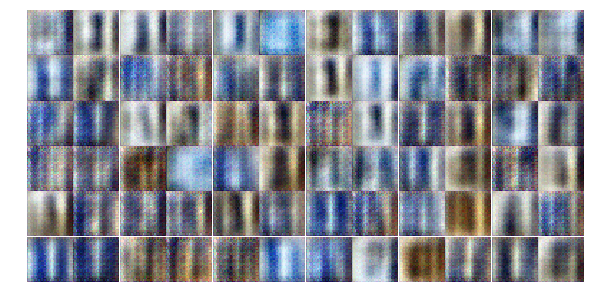

Epoch 1/25... Discriminator Loss: 0.6106... Generator Loss: 2.0511
Epoch 1/25... Discriminator Loss: 0.2560... Generator Loss: 2.9601
Epoch 1/25... Discriminator Loss: 0.8958... Generator Loss: 2.8153
Epoch 1/25... Discriminator Loss: 1.5905... Generator Loss: 0.3846
Epoch 1/25... Discriminator Loss: 0.8915... Generator Loss: 2.2725
Epoch 1/25... Discriminator Loss: 0.9038... Generator Loss: 1.0186
Epoch 1/25... Discriminator Loss: 0.3962... Generator Loss: 2.2577
Epoch 1/25... Discriminator Loss: 0.7617... Generator Loss: 1.2317
Epoch 1/25... Discriminator Loss: 0.6024... Generator Loss: 2.5825
Epoch 1/25... Discriminator Loss: 0.9762... Generator Loss: 0.8838


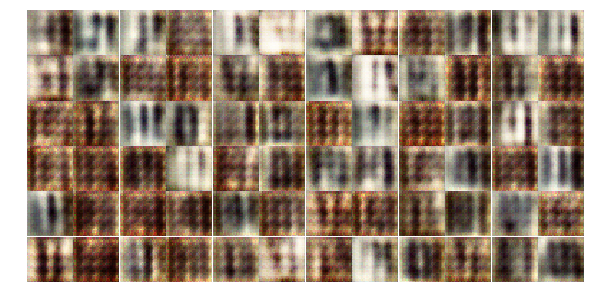

Epoch 1/25... Discriminator Loss: 1.1018... Generator Loss: 5.2536
Epoch 1/25... Discriminator Loss: 0.4750... Generator Loss: 2.4656
Epoch 1/25... Discriminator Loss: 1.1131... Generator Loss: 0.7432
Epoch 1/25... Discriminator Loss: 0.3394... Generator Loss: 2.1063
Epoch 1/25... Discriminator Loss: 0.3736... Generator Loss: 1.9552
Epoch 1/25... Discriminator Loss: 0.5392... Generator Loss: 1.8609
Epoch 1/25... Discriminator Loss: 0.8650... Generator Loss: 0.7854
Epoch 1/25... Discriminator Loss: 1.3173... Generator Loss: 0.6973
Epoch 1/25... Discriminator Loss: 0.9469... Generator Loss: 0.7845
Epoch 1/25... Discriminator Loss: 0.6638... Generator Loss: 1.3868


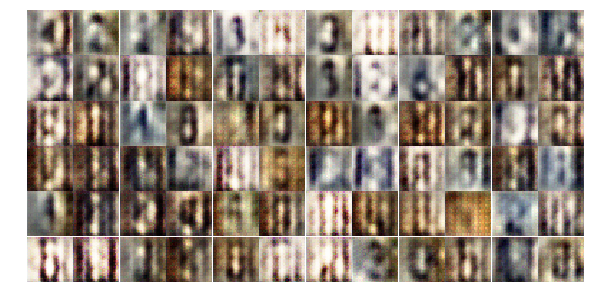

Epoch 1/25... Discriminator Loss: 0.7522... Generator Loss: 1.6798
Epoch 1/25... Discriminator Loss: 0.7740... Generator Loss: 0.9810
Epoch 1/25... Discriminator Loss: 0.6632... Generator Loss: 1.2514
Epoch 1/25... Discriminator Loss: 0.5512... Generator Loss: 1.6160
Epoch 1/25... Discriminator Loss: 0.8104... Generator Loss: 1.3201
Epoch 1/25... Discriminator Loss: 0.6875... Generator Loss: 1.4148
Epoch 1/25... Discriminator Loss: 0.9708... Generator Loss: 1.1513
Epoch 1/25... Discriminator Loss: 0.4402... Generator Loss: 1.8684
Epoch 1/25... Discriminator Loss: 0.6254... Generator Loss: 1.6218
Epoch 1/25... Discriminator Loss: 0.5418... Generator Loss: 2.0632


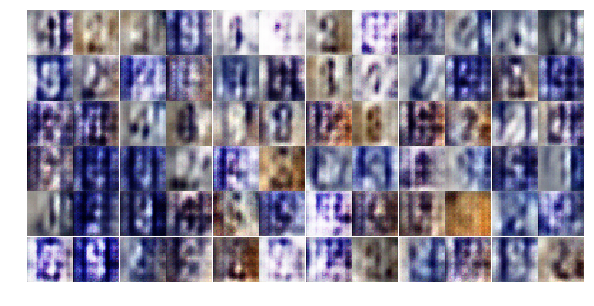

Epoch 1/25... Discriminator Loss: 0.9033... Generator Loss: 0.9128
Epoch 1/25... Discriminator Loss: 0.8468... Generator Loss: 1.2670
Epoch 1/25... Discriminator Loss: 1.0115... Generator Loss: 1.0214
Epoch 1/25... Discriminator Loss: 0.8803... Generator Loss: 1.0319
Epoch 1/25... Discriminator Loss: 1.3149... Generator Loss: 0.6402
Epoch 1/25... Discriminator Loss: 0.9452... Generator Loss: 1.0163
Epoch 1/25... Discriminator Loss: 0.9719... Generator Loss: 0.8100
Epoch 1/25... Discriminator Loss: 1.2070... Generator Loss: 0.6711
Epoch 1/25... Discriminator Loss: 1.6207... Generator Loss: 1.8553
Epoch 1/25... Discriminator Loss: 0.9973... Generator Loss: 0.9505


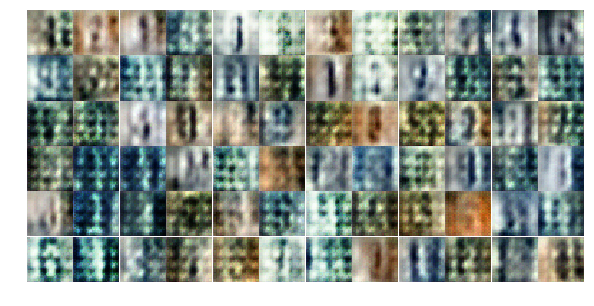

Epoch 1/25... Discriminator Loss: 1.5711... Generator Loss: 0.5977
Epoch 1/25... Discriminator Loss: 1.1134... Generator Loss: 0.9135
Epoch 1/25... Discriminator Loss: 1.2137... Generator Loss: 0.6756
Epoch 1/25... Discriminator Loss: 1.0489... Generator Loss: 1.2467
Epoch 1/25... Discriminator Loss: 1.3946... Generator Loss: 0.6609
Epoch 1/25... Discriminator Loss: 1.0103... Generator Loss: 1.0516
Epoch 1/25... Discriminator Loss: 0.9246... Generator Loss: 0.9750
Epoch 1/25... Discriminator Loss: 0.7010... Generator Loss: 1.7237
Epoch 1/25... Discriminator Loss: 1.2644... Generator Loss: 0.7311
Epoch 1/25... Discriminator Loss: 1.0590... Generator Loss: 0.9336


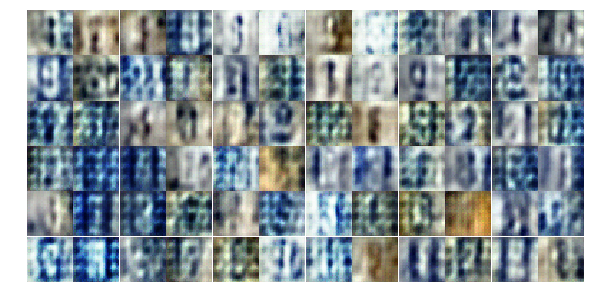

Epoch 1/25... Discriminator Loss: 0.9773... Generator Loss: 1.1540
Epoch 1/25... Discriminator Loss: 0.9506... Generator Loss: 1.2597
Epoch 1/25... Discriminator Loss: 1.2510... Generator Loss: 0.7101
Epoch 1/25... Discriminator Loss: 1.2127... Generator Loss: 0.6996
Epoch 1/25... Discriminator Loss: 1.0149... Generator Loss: 0.9682
Epoch 1/25... Discriminator Loss: 1.0852... Generator Loss: 1.0574
Epoch 1/25... Discriminator Loss: 1.1344... Generator Loss: 0.9589
Epoch 1/25... Discriminator Loss: 1.2719... Generator Loss: 0.8402
Epoch 1/25... Discriminator Loss: 0.7533... Generator Loss: 1.0690
Epoch 1/25... Discriminator Loss: 0.8891... Generator Loss: 0.9223


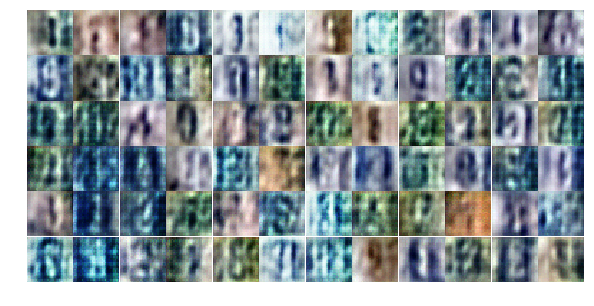

Epoch 1/25... Discriminator Loss: 1.2231... Generator Loss: 0.9976
Epoch 1/25... Discriminator Loss: 1.1367... Generator Loss: 0.8633
Epoch 1/25... Discriminator Loss: 1.4495... Generator Loss: 0.5628
Epoch 1/25... Discriminator Loss: 0.9674... Generator Loss: 1.1179
Epoch 1/25... Discriminator Loss: 1.0357... Generator Loss: 0.8632
Epoch 1/25... Discriminator Loss: 1.2552... Generator Loss: 0.9057
Epoch 1/25... Discriminator Loss: 0.8824... Generator Loss: 1.2403
Epoch 1/25... Discriminator Loss: 0.9398... Generator Loss: 1.1387
Epoch 1/25... Discriminator Loss: 1.0194... Generator Loss: 1.1095
Epoch 1/25... Discriminator Loss: 1.4842... Generator Loss: 0.6567


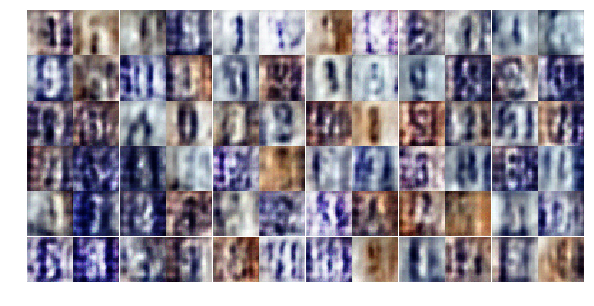

Epoch 1/25... Discriminator Loss: 0.8736... Generator Loss: 0.9440
Epoch 1/25... Discriminator Loss: 0.9203... Generator Loss: 1.1383
Epoch 1/25... Discriminator Loss: 0.8505... Generator Loss: 1.1111
Epoch 1/25... Discriminator Loss: 0.9862... Generator Loss: 1.2146
Epoch 1/25... Discriminator Loss: 1.3799... Generator Loss: 0.9471
Epoch 1/25... Discriminator Loss: 0.8896... Generator Loss: 1.1417
Epoch 1/25... Discriminator Loss: 1.0921... Generator Loss: 0.8372
Epoch 1/25... Discriminator Loss: 1.4674... Generator Loss: 0.4462
Epoch 1/25... Discriminator Loss: 0.9056... Generator Loss: 1.0107
Epoch 1/25... Discriminator Loss: 1.1150... Generator Loss: 1.3080


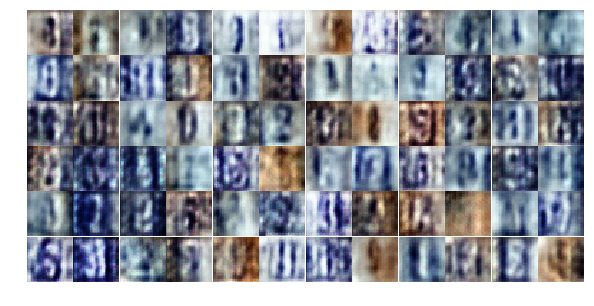

Epoch 1/25... Discriminator Loss: 0.8388... Generator Loss: 1.1955
Epoch 1/25... Discriminator Loss: 0.8944... Generator Loss: 1.6050
Epoch 1/25... Discriminator Loss: 1.1339... Generator Loss: 0.8994
Epoch 1/25... Discriminator Loss: 0.8766... Generator Loss: 0.9695
Epoch 2/25... Discriminator Loss: 0.9613... Generator Loss: 1.1577
Epoch 2/25... Discriminator Loss: 1.0679... Generator Loss: 0.7468
Epoch 2/25... Discriminator Loss: 1.0828... Generator Loss: 1.0421
Epoch 2/25... Discriminator Loss: 0.9801... Generator Loss: 0.9154
Epoch 2/25... Discriminator Loss: 1.0176... Generator Loss: 0.8366
Epoch 2/25... Discriminator Loss: 1.0766... Generator Loss: 1.4225


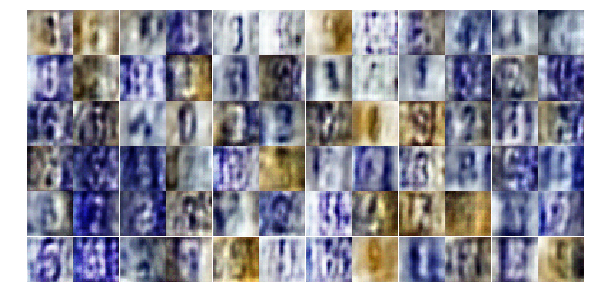

Epoch 2/25... Discriminator Loss: 1.2815... Generator Loss: 1.1600
Epoch 2/25... Discriminator Loss: 0.8874... Generator Loss: 0.9759
Epoch 2/25... Discriminator Loss: 0.9815... Generator Loss: 0.9232
Epoch 2/25... Discriminator Loss: 0.8463... Generator Loss: 1.0142
Epoch 2/25... Discriminator Loss: 1.2299... Generator Loss: 1.0634
Epoch 2/25... Discriminator Loss: 0.8592... Generator Loss: 1.1807
Epoch 2/25... Discriminator Loss: 1.1347... Generator Loss: 0.9370
Epoch 2/25... Discriminator Loss: 1.0607... Generator Loss: 0.8536
Epoch 2/25... Discriminator Loss: 1.3901... Generator Loss: 0.6615
Epoch 2/25... Discriminator Loss: 0.7820... Generator Loss: 1.1545


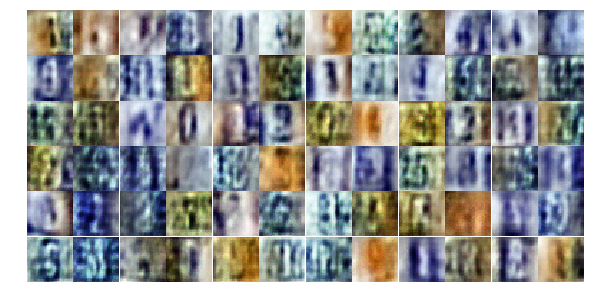

Epoch 2/25... Discriminator Loss: 1.0976... Generator Loss: 0.7474
Epoch 2/25... Discriminator Loss: 1.0921... Generator Loss: 0.7622
Epoch 2/25... Discriminator Loss: 0.7485... Generator Loss: 1.1496
Epoch 2/25... Discriminator Loss: 0.9718... Generator Loss: 1.2048
Epoch 2/25... Discriminator Loss: 0.7486... Generator Loss: 1.5545
Epoch 2/25... Discriminator Loss: 1.5323... Generator Loss: 0.3634
Epoch 2/25... Discriminator Loss: 0.7663... Generator Loss: 1.3008
Epoch 2/25... Discriminator Loss: 1.1176... Generator Loss: 0.5568
Epoch 2/25... Discriminator Loss: 0.8101... Generator Loss: 1.2635
Epoch 2/25... Discriminator Loss: 0.7194... Generator Loss: 1.6345


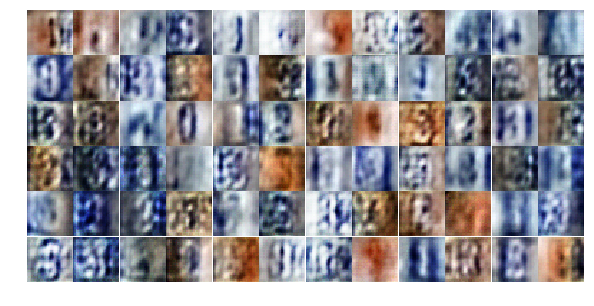

Epoch 2/25... Discriminator Loss: 0.9678... Generator Loss: 1.0780
Epoch 2/25... Discriminator Loss: 0.5569... Generator Loss: 1.7467
Epoch 2/25... Discriminator Loss: 0.7415... Generator Loss: 0.9865
Epoch 2/25... Discriminator Loss: 1.1684... Generator Loss: 0.6334
Epoch 2/25... Discriminator Loss: 0.9520... Generator Loss: 0.6937
Epoch 2/25... Discriminator Loss: 0.9603... Generator Loss: 1.3247
Epoch 2/25... Discriminator Loss: 0.5554... Generator Loss: 1.4636
Epoch 2/25... Discriminator Loss: 1.0032... Generator Loss: 0.7514
Epoch 2/25... Discriminator Loss: 0.6471... Generator Loss: 1.5658
Epoch 2/25... Discriminator Loss: 1.0339... Generator Loss: 0.7692


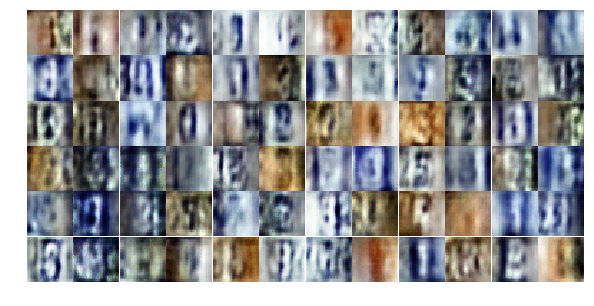

Epoch 2/25... Discriminator Loss: 0.8969... Generator Loss: 1.3407
Epoch 2/25... Discriminator Loss: 0.7803... Generator Loss: 1.3146
Epoch 2/25... Discriminator Loss: 0.6212... Generator Loss: 1.2512
Epoch 2/25... Discriminator Loss: 0.6346... Generator Loss: 1.2970
Epoch 2/25... Discriminator Loss: 0.7921... Generator Loss: 1.2346
Epoch 2/25... Discriminator Loss: 0.7174... Generator Loss: 3.6013
Epoch 2/25... Discriminator Loss: 1.0381... Generator Loss: 0.7682
Epoch 2/25... Discriminator Loss: 0.7087... Generator Loss: 1.1948
Epoch 2/25... Discriminator Loss: 1.0842... Generator Loss: 0.5883
Epoch 2/25... Discriminator Loss: 0.8654... Generator Loss: 0.9951


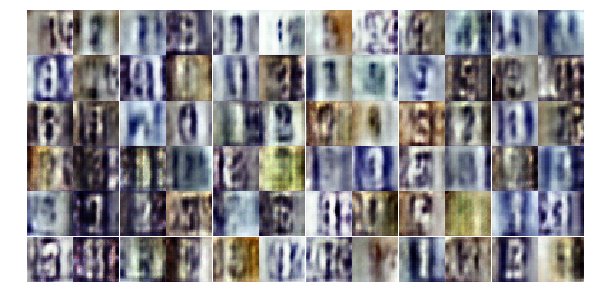

Epoch 2/25... Discriminator Loss: 1.3274... Generator Loss: 0.6249
Epoch 2/25... Discriminator Loss: 0.9140... Generator Loss: 1.2400
Epoch 2/25... Discriminator Loss: 0.6381... Generator Loss: 1.7946
Epoch 2/25... Discriminator Loss: 0.7862... Generator Loss: 1.3018
Epoch 2/25... Discriminator Loss: 0.4893... Generator Loss: 1.5574
Epoch 2/25... Discriminator Loss: 0.8458... Generator Loss: 1.0416
Epoch 2/25... Discriminator Loss: 0.9077... Generator Loss: 0.7666
Epoch 2/25... Discriminator Loss: 0.6284... Generator Loss: 0.9869
Epoch 2/25... Discriminator Loss: 0.7340... Generator Loss: 1.1403
Epoch 2/25... Discriminator Loss: 0.5556... Generator Loss: 1.8508


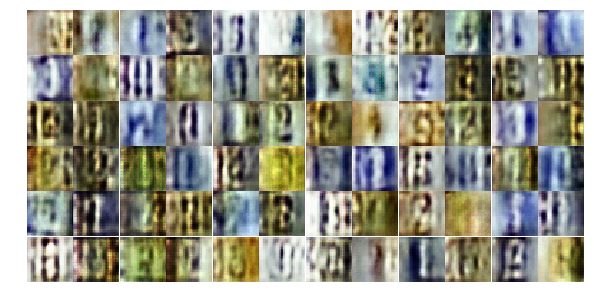

Epoch 2/25... Discriminator Loss: 0.4531... Generator Loss: 1.4312
Epoch 2/25... Discriminator Loss: 0.7288... Generator Loss: 1.2269
Epoch 2/25... Discriminator Loss: 0.5483... Generator Loss: 1.3848
Epoch 2/25... Discriminator Loss: 1.7665... Generator Loss: 0.2602
Epoch 2/25... Discriminator Loss: 0.7257... Generator Loss: 1.0605
Epoch 2/25... Discriminator Loss: 0.5748... Generator Loss: 1.4058


In [ ]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))